In [1]:
import os
import sys
import logging
import itertools

import pandas as pd
import numpy as np
import re
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import wordcloud
from wordcloud import WordCloud

import tensorflow_hub as hub
import bert
from bert import tokenization

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

init_notebook_mode(connected=True)

log = logging.getLogger(name=__name__)
log.setLevel(logging.INFO)
logging.captureWarnings(True)
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

ch.setFormatter(formatter)
log.addHandler(ch)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 160

SEED = 1
tf.random.set_seed(
    SEED
)

log.info(f"Python version: {sys.version}")
log.info(f"Numpy version: {np.__version__}")
log.info(f"Pandas version: {pd.__version__}")
log.info(f"Scikit-learn version: {sklearn.__version__}")
log.info(f"TensorFlow version: {tf.__version__}")
log.info(f"Plotly version: {plotly.__version__}")
log.info(f"WordCloud version: {wordcloud.__version__}")
log.info(f"tensorflow.random seed: {SEED}")

UNK = "UNK"
NUM = "QNUM"
AT = "QAT"
http = "http"
html = "html"
SUCCESS = 0
stopwords = (nltk.corpus.stopwords.words("english") 
    + ["u", "im", "st", "nd", "rd", "th"]
)

old_text = "text"
text = "t"
hashtag = "hashtag"
at = "at"
href = "href"
target = "target"
keyword = "keyword"
location = "location"

y_cols = [target+"_0", target+"_1"]

data_bn = "data"
data_dir = os.path.abspath(
    os.path.join(__name__, os.pardir, os.pardir, data_bn)
)

log.info(f"Data directory: {data_dir}")

train_bn = "train.csv"
test_bn = "test.csv"
train_fn = os.path.join(data_dir, train_bn)
test_fn = os.path.join(data_dir, test_bn)

df_train = pd.read_csv(train_fn)
df_test = pd.read_csv(test_fn)

log.info(f"Training data shape: {df_train.shape}")
log.info(f"Test data shape: {df_test.shape}")

train_pts = df_train.shape[0]

2020-11-10 23:25:32,844 - __main__ - INFO - Python version: 3.8.0 (default, Oct 28 2019, 16:14:01) 
[GCC 8.3.0]
2020-11-10 23:25:32,845 - __main__ - INFO - Numpy version: 1.18.5
2020-11-10 23:25:32,845 - __main__ - INFO - Pandas version: 1.1.4
2020-11-10 23:25:32,845 - __main__ - INFO - Scikit-learn version: 0.23.2
2020-11-10 23:25:32,846 - __main__ - INFO - TensorFlow version: 2.3.0
2020-11-10 23:25:32,847 - __main__ - INFO - Plotly version: 4.12.0
2020-11-10 23:25:32,847 - __main__ - INFO - WordCloud version: 1.8.0
2020-11-10 23:25:32,848 - __main__ - INFO - tensorflow.random seed: 1
2020-11-10 23:25:32,850 - __main__ - INFO - Data directory: /home/jimmy/github/kaggle/nlp_disaster_tweets/data
2020-11-10 23:25:32,877 - __main__ - INFO - Training data shape: (7613, 5)
2020-11-10 23:25:32,878 - __main__ - INFO - Test data shape: (3263, 4)


In [2]:
class LabelEncoderExt(preprocessing.LabelEncoder):
    """
    """
    def __init__(self):

        super().__init__()

    def fit(self, y):

        if not isinstance(y, np.ndarray):
            y = np.array(y)
        assert (len(y.shape) == 1), "Require 1D array"
        y = np.concatenate((y, np.array([UNK])))
        super().fit(y)

    def transform(self, y):

        y[~np.isin(y, self.classes_, assume_unique=True)] = UNK
        return super().transform(y)

    def fit_transform(self, y):

        self.fit(y)
        return self.transform(y)

In [3]:
def to_lower(df, col=text):
    """
    Casefolds (casts to lower case) text column of dataframe ${df} inplace.
    """
    df[col] = df[col].apply(lambda x: x.casefold())
    
    return SUCCESS


def hash_handling(df, col=text):
    """
    Removes # as well as copying strings of the form #\w+ into
        a new column called ${hastag}. This function alters ${df} inplace.
    """
    reg_hash_full = re.compile("(#)\w+")
    reg_hash = re.compile("(#)")
    
    f = lambda x: [y.group() for y in reg_hash_full.finditer(x)]
    g = lambda x: ' '.join(x)
    
    df[hashtag] = df[text].apply(f).apply(g)
    df[col] = df[col].apply(lambda x: reg_hash.sub(' ', x))
    
    return SUCCESS


def at_handling(df, col=text):
    """
    Removes words of the form @\w+ replacing those with the literal ${AT}
        as well as preserving the strings of the form @\w+ in the new
        column ${at}. This function alters ${df} inplace.
    """
    reg_at = re.compile("(@)")
    reg_at_full = re.compile("(@)\w+")
    
    f = lambda x: [y.group() for y in reg_at_full.finditer(x)]
    g = lambda x: ' '.join(x)
    
    df[at] = df[col].apply(f).apply(g)
    df[col] = df[col].apply(lambda x: reg_at_full.sub(' '+AT+' ', x))
    
    return SUCCESS


def count_at(df):
    """
    """
    df[at] = df[at].apply(lambda x: len(x.split()))
    
    return SUCCESS


def href_handling(df):
    '''
    '''
    reg_href_full = re.compile("(htt)\S+")
    
    f = lambda x: len(list(reg_href_full.finditer(x)))
    
    df[href] = df[text].apply(f)
    df[text] = df[text].apply(lambda x: reg_href_full.sub(' '+http+' ', x))
    
    return SUCCESS


def html_special_handling(df):
    '''
    '''
    reg_html = re.compile("(&)\w+(;)")
    df[text] = df[text].apply(lambda x: reg_html.sub(' '+html+' ', x))
    
    return SUCCESS
    
    
def xc2x89_byte_handling(df):
    '''
    '''
    reg_x89 = re.compile(b"\xc2\x89".decode('utf-8')+"\S+")
    df[text] = df[text].apply(lambda x: reg_x89.sub(' ', x))
    
    return SUCCESS
    
    
def special_char_handling(df):
    '''
    '''
    reg_special = re.compile("[^\w\s]")
    df[text] = df[text].apply(lambda x: reg_special.sub(' ', x))
    df[text] = df[text].apply(lambda x: re.sub('_', ' ', x)) 
    
    return SUCCESS


def contraction_handling(df):
    '''
    '''
    reg_contract = re.compile("\s(s|m|t|(nt)|(ve)|w)\s")
    df[text] = df[text].apply(lambda x: reg_contract.sub(' ', x))
    
    return SUCCESS


def encode_numerals(df):
    '''
    '''
    reg_numerals = re.compile("\d+[\s\d]*")
    df[text] = df[text].apply(lambda x: reg_numerals.sub(' '+NUM+' ', x))
    
    return SUCCESS
    
    
def remove_stopwords(df):
    """
    """
    f = (lambda x: 
        ' '.join([y for y in x.strip().split() if y not in stopwords])
    )
    df[text] = df[text].apply(f)
    
    return SUCCESS   


def has_location(df):
    """
    """
    df[location] = df[location].apply(lambda x: 1 if pd.isnull(x) else 0)
    
    return SUCCESS


def preprocess(df):
    """
    """
    df[text] = df[old_text]
    df[keyword].fillna('', inplace=True)
    to_lower(df)
    hash_handling(df)
    at_handling(df)
    href_handling(df)
    html_special_handling(df)
    xc2x89_byte_handling(df)
    special_char_handling(df)
    contraction_handling(df)
    remove_stopwords(df)
    encode_numerals(df)
    has_location(df)
    
    return SUCCESS

In [4]:
def tokenize_dataframe(df, col, max_len=20):
    """
    """
    df_tmp = pd.DataFrame(df[col].apply(lambda x: reversed(x.split())).tolist())
    orig_len = len(df_tmp.columns)
    df_tmp = df_tmp.rename(
        lambda x: col+"_{:02d}".format(max_len-1-x), 
        axis=1
    )
    
    enum_cols = [col+"_{:02d}".format(i) for i in range(max_len)]
    if orig_len < max_len:
        compl_cols = [x for x in enum_cols if x not in df_tmp.columns]
        df_tmp[compl_cols] = np.nan

    df_merged = df.merge(
        df_tmp[enum_cols],
        how="outer",
        left_index=True,
        right_index=True
    )
    
    return df_merged, enum_cols


def filter_infrequent(df, cols, cutoff=5):
    """
    """
    unique_words, word_counts = (
        np.unique(df[cols].values.flatten(), return_counts=True)
    )
    infreq_dict = {
        x: (x if word_counts[i] >= cutoff else UNK)
            for i, x in np.ndenumerate(unique_words)
    }

    f = lambda x: infreq_dict[x]
    df[cols] = df[cols].applymap(f)
    
    return SUCCESS


def transform_data(df):
    """
    """
    df, word_cols = tokenize_dataframe(df, text, max_len=25)
    
    df[word_cols] = df[word_cols].fillna('')
    
    lemmatizer = WordNetLemmatizer() 
    ps = PorterStemmer()

    df[word_cols] = df[text_cols].applymap(lambda x: ps.stem(x))
    df[word_cols] = df[text_cols].applymap(lambda x: lemmatizer.lemmatize(x))

    _ = filter_infrequent(df, word_cols, cutoff=10)
        
    enc = LabelEncoderExt()
    df[word_cols] = (enc
        .fit_transform(df[word_cols].values.flatten())
        .reshape(df[word_cols].shape)
    )

    num_unique_words = enc.classes_.shape[0]

    log.info(f"Number of unique words: {num_unique_words}")
    
    return enc, num_unique_words, word_cols

In [5]:
_ = preprocess(df_train)
_ = preprocess(df_test)

In [6]:
df_train.head(10)

,id,keyword,location,text,target,t,hashtag,at,href
0,1,,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deeds reason earthquake may allah forgive us,#earthquake,,0
1,4,,1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,,,0
2,5,,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected,,,0
3,6,,1,"13,000 people receive #wildfires evacuation orders in California",1,QNUM people receive wildfires evacuation orders california,#wildfires,,0
4,7,,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfires pours school,#alaska #wildfires,,0
5,8,,1,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,rockyfire update california hwy QNUM closed directions due lake county fire cafire wildfires,#rockyfire #cafire #wildfires,,0
6,10,,1,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,flood disaster heavy rain causes flash flooding streets manitou colorado springs areas,#flood #disaster,,0
7,13,,1,I'm on top of the hill and I can see a fire in the woods...,1,top hill see fire woods,,,0
8,14,,1,There's an emergency evacuation happening now in the building across the street,1,emergency evacuation happening building across street,,,0
9,15,,1,I'm afraid that the tornado is coming to our area...,1,afraid tornado coming area,,,0


In [7]:
df_test.head(10)

,id,keyword,location,text,t,hashtag,at,href
0,0,,1,Just happened a terrible car crash,happened terrible car crash,,,0
1,2,,1,"Heard about #earthquake is different cities, stay safe everyone.",heard earthquake different cities stay safe everyone,#earthquake,,0
2,3,,1,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond geese fleeing across street cannot save,,,0
3,9,,1,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,#spokane #wildfires,,0
4,11,,1,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills QNUM china taiwan,,,0
5,12,,1,We're shaking...It's an earthquake,shaking earthquake,,,0
6,21,,1,"They'd probably still show more life than Arsenal did yesterday, eh? EH?",probably still show life arsenal yesterday eh eh,,,0
7,22,,1,Hey! How are you?,hey,,,0
8,27,,1,What a nice hat?,nice hat,,,0
9,29,,1,Fuck off!,fuck,,,0


...


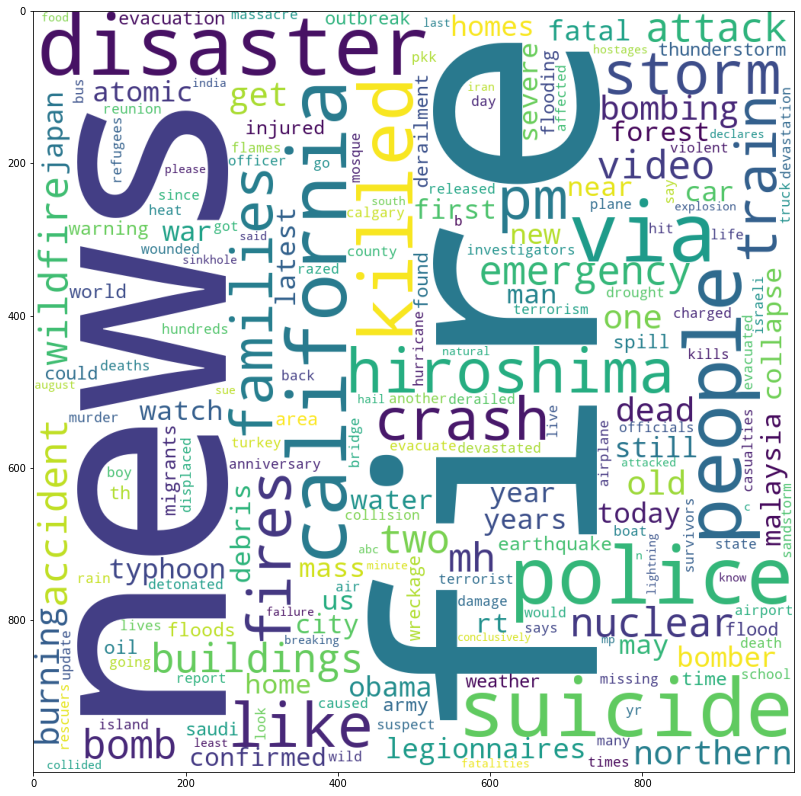

In [8]:
tokenize_flatten = lambda series: (
    list(itertools.chain(*[x.split() for x in series]))
)

wc_size = (14, 14)

tdf = df_train[df_train[target]==1]

unique_words, word_counts = (
    np.unique(tokenize_flatten(tdf[text]), return_counts=True)
)
sm = np.sum(word_counts)
frequency_dict = {
    x: word_counts[i]/sm 
        for i, x in np.ndenumerate(unique_words)
}
try:
    frequency_dict.pop(NUM)
    frequency_dict.pop(AT)
    frequency_dict.pop(http)
    frequency_dict.pop(html)
    frequency_dict.pop(UNK)
except:
    print("...")

wordcloud = WordCloud(
    width=1000, height=1000, 
    background_color='white',
    min_font_size=10
).generate_from_frequencies(frequency_dict)
fig = plt.figure(figsize=wc_size, facecolor=None)
ax = fig.add_subplot()
a = ax.imshow(wordcloud) 

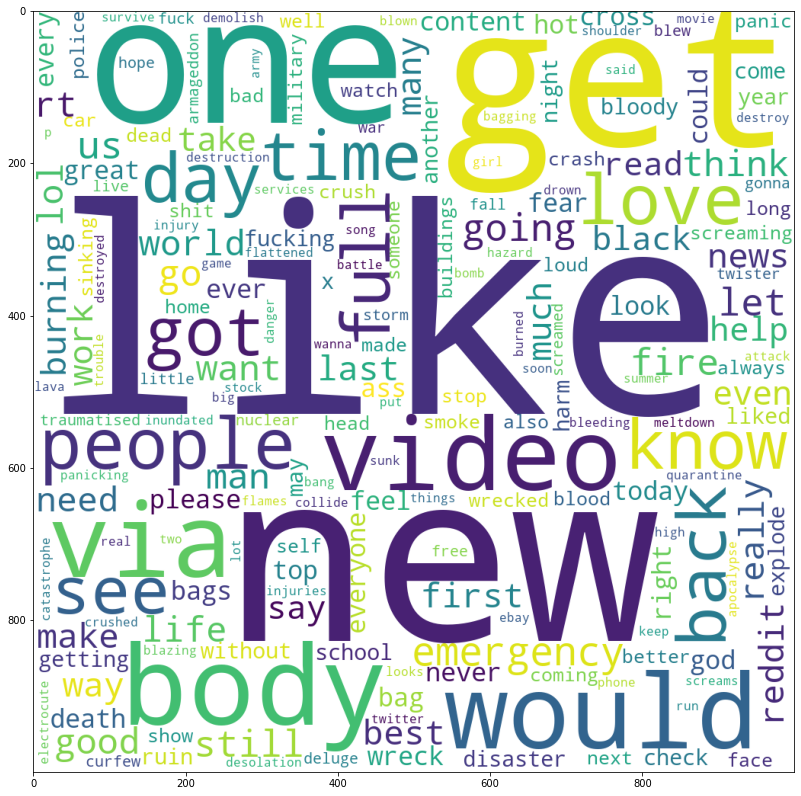

In [9]:
tdf = df_train[df_train[target]==0]
unique_words, word_counts = (
    np.unique(tokenize_flatten(tdf[text]), return_counts=True)
)
sm = np.sum(word_counts)
frequency_dict = {
    x: word_counts[i]/sm
    for i, x in np.ndenumerate(unique_words)
}
try:
    frequency_dict.pop(NUM)
    frequency_dict.pop(AT)
    frequency_dict.pop(http)
    frequency_dict.pop(html)
    frequency_dict.pop(UNK)
except:
    pass

wordcloud = WordCloud(
    width=1000, height=1000, 
    background_color='white',
    min_font_size=10
).generate_from_frequencies(frequency_dict)
fig = plt.figure(figsize=wc_size, facecolor=None) 
ax = fig.add_subplot()
ret = ax.imshow(wordcloud) 

In [10]:
def bigrams_count(df, col, top_n=10):
    """
    """
    words = [x.split() for x in df[col]]
    bigrams = [x[i]+"_"+x[i+1] for x in words for i in range(len(x)-1)]
    
    uniq_pairs, counts = np.unique(np.array(bigrams), return_counts=True)
        
    return np.array([uniq_pairs, counts])

In [11]:
df_bi_0 = pd.DataFrame(
    bigrams_count(df_train[df_train[target]==0], text).T, 
    columns=["bigram", "count"]
)
df_bi_1 = pd.DataFrame(
    bigrams_count(df_test[df_train[target]==0], text).T, 
    columns=["bigram", "count"]
)

df_bi = df_bi_0.merge(df_bi_1, how="outer", left_on="bigram", 
                      suffixes=("_0", "_1"), right_on="bigram")
df_bi.fillna(0, inplace=True)
df_bi = df_bi.astype({"count_0": int, "count_1": int})
df_bi["total"] = df_bi["count_0"] + df_bi["count_1"]

In [12]:
top_n = 100
top_bigrams = df_bi.nlargest(top_n, "total")

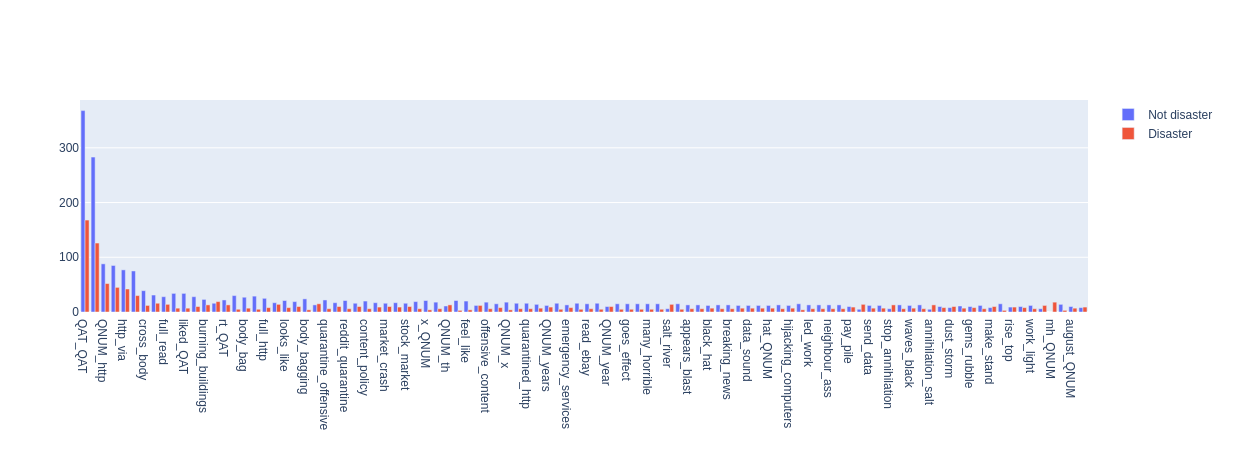

In [13]:
fig = go.Figure()
bar0 = go.Bar(name="Not disaster", 
              x=top_bigrams["bigram"], 
              y=top_bigrams["count_0"]
)
bar1 = go.Bar(name="Disaster",
              x=top_bigrams["bigram"],
              y=top_bigrams["count_1"]
)

fig.add_trace(bar0)
fig.add_trace(bar1)

fig.update_layout(barmode='group')

iplot(fig)

In [14]:
def bert_tokenize(df, col):
    """
    """
    gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"

    tf.io.gfile.listdir(gs_folder_bert)

    tokenizer = bert.tokenization.FullTokenizer(
        vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
        do_lower_case=True
    )

    bert_token = (lambda x: tokenizer
        .convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
    )
    
    num_unique_words = len(tokenizer.vocab)
    log.info("Vocab size:", len(tokenizer.vocab))

    pre_words_ids = df[col].apply(bert_token)
    pre_masks = df_train[col].apply(lambda x: [1]*(len(tokenizer.tokenize(x))+2))

    words_ids = pad_sequences(pre_words_ids)
    masks = pad_sequences(pre_masks)
    type_ids = np.zeros(words_ids.shape, dtype=np.int)

    word_cols = [text+"_{:02d}".format(i) for i in range(words_ids.shape[1])]
    mask_cols = ["mask"+"_{:02d}".format(i) for i in range(words_ids.shape[1])]
    type_cols = ["type"+"_{:02d}".format(i) for i in range(words_ids.shape[1])]

    df[word_cols] = words_ids
    df[mask_cols] = masks
    df[type_cols] = type_ids
    
    return tokenizer, num_unique_words, word_cols, mask_cols, type_cols

In [15]:
def tf_tokenizer(df, col, num_words):
    """
    """
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(df[col].values)
    word_ar = pad_sequences(
        tokenizer.texts_to_sequences(df[col].values)
    )
    word_cols = ["text_{:02d}".format(i) for i in range(word_ar.shape[1])]
    df[word_cols] = word_ar
    
    return tokenizer, num_words, word_cols

In [16]:
df_full = pd.concat([df_train, df_test], ignore_index=True)

In [17]:
#enc, num_unique_words, word_cols = transform_data(df_full)
tokenizer, num_unique_words, word_cols = tf_tokenizer(df_full, text, 1000)
#tokenizer, num_unique_words, word_cols, mask_cols, type_cols = bert_tokenize(df_full, text)

In [18]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
#'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(hub_url_bert, trainable=True)

In [19]:
class TwolayerModel(tf.keras.Model):
    """
    """
    def __init__(self,
        batch_size=32,
        units=40,
        embed_dim=100,
        sequence_length=len(word_cols),
    ):
        """
        """
        super(TwolayerModel, self).__init__()

        self.inps = (None, sequence_length)
        self.bs = batch_size
        out_dim = 2        
        
        self._embed1 = tf.keras.layers.Embedding(
            num_unique_words,
            embed_dim,
            input_length=self.inps[1],
            name="word_embedding",
        )
        self._lstm1 = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units,
                name="lstm1",
                return_sequences=True,
            )
        )
        
        self._lstm2 = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units,
                name="lstm2",
            )
        )

        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.build(self.inps)
        

    def call(self, inputs):        
        x1 = self._embed1(inputs)
        y1 = self._lstm1(x1)
        y1 = self._lstm2(y1)
        out = self._dense2(y1)
        
        return out
    

    
class OnelayerModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=32,
            units=40,
            embed_dim=100,
            sequence_length=len(word_cols),
    ):
        """
        """
        super(OnelayerModel, self).__init__()

        self.inps = [
            (None, sequence_length),
            (None, sequence_length),
            (None, sequence_length),
        ]
        self.bs = batch_size
        out_dim = 2
              
        self._embed1 = tf.keras.layers.Embedding(
            num_unique_words,
            embed_dim,
            input_length=self.inps[0][1],
            name="word_embedding",
        )
        self._lstm1 = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units,
                name="lstm1",
            )
        )
        
        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(
                            learning_rate=0.0001
        )
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.build(self.inps[0])
        

    def call(self, inputs):        
        x1 = self._embed1(inputs)
        y1 = self._lstm1(x1)
        out = self._dense2(y1)
        
        return out
    
    
class ConvModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=32,
            units=40,
            embed_dim=100,
            sequence_length=len(word_cols),
    ):
        """
        """
        self.inps = (None, sequence_length)
        self.bs = batch_size
        out_dim = 2
        
        super(ConvModel, self).__init__()
        
        self._embed1 = tf.keras.layers.Embedding(
            num_unique_words,
            embed_dim,
            input_length=self.inps[1],
            name="word_embedding",
        )
            
        filters = 100
        window = 5
        
        self._conv1 = tf.keras.layers.Conv1D(
            filters,
            window
        )
        
        self._flatten = tf.keras.layers.Flatten()
        
        self._dense1 = tf.keras.layers.Dense(
            units,
            activation=tf.nn.relu,
            name="dense",
        )
        
        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(
                            learning_rate=0.0001
        )
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.build(self.inps)
        

    def call(self, inputs):
        x1 = self._embed1(inputs)
        x1 = self._conv1(x1)
        y1 = self._flatten(x1)
        z = self._dense1(y1)
        out = self._dense2(z)
        
        return out
    
    
class BERTModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=64,
            units=40,
            embed_dim=100,
            sequence_length=len(word_cols),
    ):
        """
        """
        super(BERTModel, self).__init__()

        self.inps = [
            (None, sequence_length),
            (None, sequence_length),
            (None, sequence_length),
        ]
        self.bs = batch_size
        out_dim = 2
        
        self.max_seq_length = sequence_length
        self.bert_layer = bert_layer
        
        self.input_word_ids = tf.keras.Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        self.input_m = tf.keras.Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        self.segment_ids = tf.keras.Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')  
        
        self._dense0 = tf.keras.layers.Dense(units, activation=tf.nn.relu)
        self._do0 = tf.keras.layers.Dropout(0.5)
        '''
        self._dense1= tf.keras.layers.Dense(units, activation=tf.nn.relu)
        self._do1 = tf.keras.layers.Dropout(0.5)
        '''
        
        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        #self.build(self.inps)
        #self.build([input_word_ids, input_mask, segment_ids])

    def call(self, inputs):        
        self.input_word_ids, self.input_m, self.segment_ids  = inputs
        pooled_output, sequence_output = self.bert_layer([self.input_word_ids, self.input_m, self.segment_ids])   
        clf_output = sequence_output[:, 0, :]
        z = self._dense0(clf_output)
        z = self._do0(z)
        #z = self._dense1(z)
        #z = self._do1(z)
        out = self._dense2(z)
        
        return out

In [20]:
#model = TwolayerModel(batch_size=32, units=20, embed_dim=200)
#model = ConvModel(batch_size=512, units=30, embed_dim=200)
model = OnelayerModel(batch_size=256, units=50, embed_dim=200)
#model = BERTModel(batch_size=32)

model.summary()

Model: "onelayer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding (Embedding)   multiple                  200000    
_________________________________________________________________
bidirectional (Bidirectional multiple                  75600     
_________________________________________________________________
final (Dense)                multiple                  202       
_________________________________________________________________
binary_accuracy (BinaryAccur multiple                  2         
Total params: 275,804
Trainable params: 275,802
Non-trainable params: 2
_________________________________________________________________


In [21]:
tfboard_dir = "logs"
if not os.path.exists(tfboard_dir):
    os.mkdir(tfboard_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tfboard_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_binary_accuracy",
    min_delta=1e-5,
    patience=10,
    baseline=0.5,
    restore_best_weights=True,
)

In [22]:
pd.options.mode.chained_assignment = None

df_test = df_full.iloc[train_pts:]
df_train = df_full.iloc[:train_pts]

log.info(f"Dataset size: {df_train.shape[0]}")

remainder = df_train.shape[0] % model.bs
pad_size = model.bs - remainder if remainder !=0 else 0
log.info(f"Remainder from batch size: {remainder}\n"
         f"Padding {pad_size} elements."
)

X1 = df_train[word_cols].values.astype(int)

X_unpad = tf.convert_to_tensor(X1, dtype=tf.int32, name='input_word_ids')

if pad_size > 0:
    X1 = np.vstack([X1, np.zeros((pad_size, X1.shape[1])).astype(int)])

X1 = tf.convert_to_tensor(X1, dtype=tf.int32, name='input_word_ids')

df_train[y_cols] = pd.get_dummies(df_train[target], prefix=target)
Y = df_train[y_cols].values
Y_add = np.zeros((pad_size, 2))
Y_add[:, 0] = 1.0
if pad_size > 0:
    Y = np.vstack([Y, Y_add])

X_val = (X1)

X = (
    tf.data.Dataset.from_tensor_slices((X_val, Y))
        .batch(model.bs, drop_remainder=True)
)

X = X.shuffle(buffer_size=10000)

q = 5
p = 1

select = lambda x, y: (x % q <= p)
nselect = lambda x, y: ~(x % q <= p)
take = lambda x, y: y

X_train = X.enumerate().filter(nselect).map(take)
X_valid = X.enumerate().filter(select).map(take)

2020-11-10 23:25:41,629 - __main__ - INFO - Dataset size: 7613
INFO:__main__:Dataset size: 7613
2020-11-10 23:25:41,636 - __main__ - INFO - Remainder from batch size: 189
Padding 67 elements.
INFO:__main__:Remainder from batch size: 189
Padding 67 elements.


In [23]:
log.info(f"Test dataset size: {df_test.shape}")

Z1 = df_test[word_cols].values.astype(int)

Z1 = tf.convert_to_tensor(Z1, dtype=tf.int32, name='input_word_ids')

X_test = Z1

2020-11-10 23:25:41,701 - __main__ - INFO - Test dataset size: (3263, 29)
INFO:__main__:Test dataset size: (3263, 29)


df_test = df_full.iloc[train_pts:]
df_train = df_full.iloc[:train_pts]

log.info(f"Dataset size: {df_train.shape[0]}")

remainder = df_train.shape[0] % model.bs
pad_size = model.bs - remainder if remainder !=0 else 0
log.info(f"Remainder from batch size: {remainder}\n"
         f"Padding {pad_size} elements."
)

X1 = df_train[word_cols].values.astype(int)
X2 = df_train[mask_cols].values.astype(int)
X3 = df_train[type_cols].values.astype(int)

X_unpad = (
    tf.convert_to_tensor(X1, dtype=tf.int32, name='input_word_ids'),
    tf.convert_to_tensor(X2, dtype=tf.int32, name='input_mask'),
    tf.convert_to_tensor(X3, dtype=tf.int32, name='input_type_ids'),
)

if pad_size > 0:
    X1 = np.vstack([X1, np.zeros((pad_size, X1.shape[1])).astype(int)])
    X2 = np.vstack([X2, np.zeros((pad_size, X1.shape[1])).astype(int)])
    X3 = np.vstack([X3, np.zeros((pad_size, X1.shape[1])).astype(int)])

X1 = tf.convert_to_tensor(X1, dtype=tf.int32, name='input_word_ids')
X2 = tf.convert_to_tensor(X2, dtype=tf.int32, name='input_mask')
X3 = tf.convert_to_tensor(X3, dtype=tf.int32, name='input_type_ids')

df_train[y_cols] = pd.get_dummies(df_train[target], prefix=target)
Y = df_train[y_cols].values
Y_add = np.zeros((pad_size, 2))
Y_add[:, 0] = 1.0
if pad_size > 0:
    Y = np.vstack([Y, Y_add])

X_val = (X1, X2, X3)

X = (
    tf.data.Dataset.from_tensor_slices((X_val, Y))
        .batch(model.bs, drop_remainder=True)
)

X = X.shuffle(buffer_size=10000)

q = 5
p = 1

select = lambda x, y: (x % q <= p)
nselect = lambda x, y: ~(x % q <= p)
take = lambda x, y: y

X_train = X.enumerate().filter(nselect).map(take)
X_valid = X.enumerate().filter(select).map(take)

log.info(f"Test dataset size: {df_test.shape}")

Z1 = df_test[word_cols].values.astype(int)

Z2 = df_test[mask_cols].values.astype(int)
Z3 = df_test[type_cols].values.astype(int)

Z1 = tf.convert_to_tensor(Z1, dtype=tf.int32, name='input_word_ids')
Z2 = tf.convert_to_tensor(Z2, dtype=tf.int32, name='input_mask')
Z3 = tf.convert_to_tensor(Z3, dtype=tf.int32, name='input_type_ids')

X_test = (Z1, Z2, Z3)

In [24]:
solution_fn = os.path.join(data_dir, "socialmedia-disaster-tweets-DFE.csv")
df_X = pd.read_csv(solution_fn, sep=',', header=0, encoding = "ISO-8859-1")
df_X = df_X.rename({"tweetid": "id"}, axis=1).astype({"id": int})
df_X[target] = df_X["choose_one"].apply(lambda x: 1 if x=="Relevant" else 0)

df_test = df_test.merge(df_X[["id", "target"]], how="inner", left_on="id", right_on=df_X.index).rename({"target_y": target}, axis=1)

df_test = df_test.drop(["id_x", "id_y"], axis=1)

df_test[y_cols] = pd.get_dummies(df_test[target], prefix=target)
Y_test = df_test[y_cols].values

#X_valid = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(model.bs, drop_remainder=True)

In [25]:
hist = model.fit(
    X_train, 
    epochs=8,
    validation_data=X_valid,
    callbacks=[
        #tensorboard_callback, 
        early_stopping
    ],
)

#model.save(os.path.join(tfboard_dir, "model"))

Epoch 1/8
18/18 [==============================] - 2s 103ms/step - loss: 0.6911 - binary_accuracy: 0.5428 - val_loss: 0.6883 - val_binary_accuracy: 0.5498
Epoch 2/8
18/18 [==============================] - 1s 57ms/step - loss: 0.6869 - binary_accuracy: 0.5397 - val_loss: 0.6782 - val_binary_accuracy: 0.5905
Epoch 3/8
18/18 [==============================] - 1s 58ms/step - loss: 0.6785 - binary_accuracy: 0.5658 - val_loss: 0.6743 - val_binary_accuracy: 0.5853
Epoch 4/8
18/18 [==============================] - 1s 50ms/step - loss: 0.6747 - binary_accuracy: 0.5681 - val_loss: 0.6652 - val_binary_accuracy: 0.5869
Epoch 5/8
18/18 [==============================] - 1s 51ms/step - loss: 0.6701 - binary_accuracy: 0.5566 - val_loss: 0.6638 - val_binary_accuracy: 0.5798
Epoch 6/8
18/18 [==============================] - 1s 55ms/step - loss: 0.6662 - binary_accuracy: 0.5569 - val_loss: 0.6600 - val_binary_accuracy: 0.5586
Epoch 7/8
18/18 [==============================] - 1s 54ms/step - loss: 0.6

In [26]:
Y_train_pred = model.predict(X_unpad)
Y_test_pred = model.predict(X_test)

In [27]:
df_train_pred = pd.DataFrame(Y_train_pred, columns=y_cols)
df_train_pred = df_train_pred.apply(np.round).astype({x: int for x in y_cols})
df_train_pred[target] = df_train_pred["target_1"]
df_train_pred.drop(y_cols, inplace=True, axis=1)
df_train_pred["id"] = df_train["id"].values
df_train_pred = df_train_pred[["id", target]]

In [28]:
df_test_pred = pd.DataFrame(Y_test_pred, columns=y_cols)
df_test_pred = df_test_pred.apply(np.round).astype({x: int for x in y_cols})
df_test_pred[target] = df_test_pred["target_1"]
df_test_pred.drop(y_cols, inplace=True, axis=1)
df_test_pred.drop(list(df_test_pred.index[df_train.shape[0]:]), inplace=True, axis=0)

In [29]:
log.info("\n" +
    classification_report(
        df_train[target],
        df_train_pred[target],
        target_names=["Not disaster", "Disaster"]
    )
)

2020-11-10 23:25:53,871 - __main__ - INFO - 
              precision    recall  f1-score   support

Not disaster       0.63      0.93      0.75      4342
    Disaster       0.75      0.28      0.40      3271

    accuracy                           0.65      7613
   macro avg       0.69      0.60      0.58      7613
weighted avg       0.68      0.65      0.60      7613

INFO:__main__:
              precision    recall  f1-score   support

Not disaster       0.63      0.93      0.75      4342
    Disaster       0.75      0.28      0.40      3271

    accuracy                           0.65      7613
   macro avg       0.69      0.60      0.58      7613
weighted avg       0.68      0.65      0.60      7613



In [30]:
accuracy_score(df_train[target], df_train_pred[target])

0.6491527650072245

In [31]:
log.info("\n" +
    classification_report(
        df_test[target],
        df_test_pred[target],
        target_names=["Not disaster", "Disaster"]
    )
)

2020-11-10 23:25:53,916 - __main__ - INFO - 
              precision    recall  f1-score   support

Not disaster       0.63      0.93      0.75      1861
    Disaster       0.73      0.27      0.40      1402

    accuracy                           0.64      3263
   macro avg       0.68      0.60      0.57      3263
weighted avg       0.67      0.64      0.60      3263

INFO:__main__:
              precision    recall  f1-score   support

Not disaster       0.63      0.93      0.75      1861
    Disaster       0.73      0.27      0.40      1402

    accuracy                           0.64      3263
   macro avg       0.68      0.60      0.57      3263
weighted avg       0.67      0.64      0.60      3263



In [32]:
accuracy_score(df_test[target], df_test_pred[target])

0.6441924609255286

In [33]:
#df_pred.to_csv(os.path.join(data_dir, "results.csv"), index=False)

%load_ext tensorboard

%tensorboard --logdir logs

In [34]:
#!kill 3444